# Contact Temperature

The content for the current page can be downloaded (button $\Downarrow$ in the top bar).

The script is here {download}`Script <./F.pdf>`.

If you want to run the notebook press the rocket button which connects you to binder. Wait a little ...

This notebook is about getting to know the contact temperature and how it comes about.

In [1]:
# Load packages
from matplotlib import rcParams, cycler
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import HBox, VBox
#%matplotlib ipympl

## Calculation of the contact temperature between to media

Recent calculation and measurements defining human touch can be found here [NASA](https://ntrs.nasa.gov/api/citations/20100020960/downloads/20100020960.pdf).

The contact temperature $T_c$ is a special mean between the temperatures of both media weighted by their thermal effusivities $b$

```{math}
:label: Tc
\begin{equation}
T_c = \frac{b_1\, T_1 + b_2 \,T_2}{b_1 + b_2}
\end{equation}
```
with $b = \sqrt{\lambda \, \rho \, c_p}$. $\lambda$ is the thermal conductivity, $\rho$ the density and $c_p$ the mass-specific heat capacity.

In [2]:
# Calculating Tc a first example
rhocp_1 = 1000 * 4000            # human skin
lam_1    = 0.5
b_1      =(lam_1 * rhocp_1)**0.5 # thermal effusivity

rhocp_2 = 700 * 2000 # wood
lam_2    = 0.15
b_2      =(lam_2 * rhocp_2)**0.5

T_1      = 36
T_2      = 20  

Tc      = (b_1 * T_1 + b_2 * T_2) /(b_1 + b_2)
print('Contact-Temperature =', f'{Tc:.2f}', '°C')

Contact-Temperature = 32.08 °C


In [25]:
def conT(T, b2):
    T_1 = 35   # skin temperature
    T_2 = T
    b1  = (0.5 * 1000 * 4000)**0.5            # human skin
    T_c      = (b1 * T_1 + b2 * T_2) / (b1 + b2)
    return T_c
@widgets.interact(b2=(0, 2000))#_manual
def plot(b2, grid=True):
    T = np.linspace(0., 50, 100)
    fig, ax = plt.subplots(1, 1, figsize=(7, 3))
    ax.plot(T, conT(T, b2))
    ax.set_xlabel('T second medium')
    ax.set_ylabel('Contact Temperature')
    ax.grid(grid)
    ax.text(0.1, .91, 'Skin temperature 35°C', fontsize=11, transform=ax.transAxes)

interactive(children=(IntSlider(value=1000, description='b2', max=2000), Checkbox(value=True, description='gri…

```{admonition} Questions
:class: full-width
 
Do you understand the influence of the individual variables? 

If not, use the rocket and calculate with other values.;-)!

What is Tc between wood and skin?

What between Aluminum and skin?
```

Now follows the numerical calculation with the forward step method of Euler (explicit forward). For more about it look at [Euler](https://aquaulb.github.io/book_solving_pde_mooc/solving_pde_mooc/notebooks/02_TimeIntegration/02_01_EulerMethod.html).

```{admonition} Questions
:class: full-width
 
Before we discuss the programme code in the lecture, try to understand what is shown in the diagram:

- what happens at the contact point?
- What do you observe in terms of temperature changes at the edges?
- are both ok, or does physics speak against it?
```

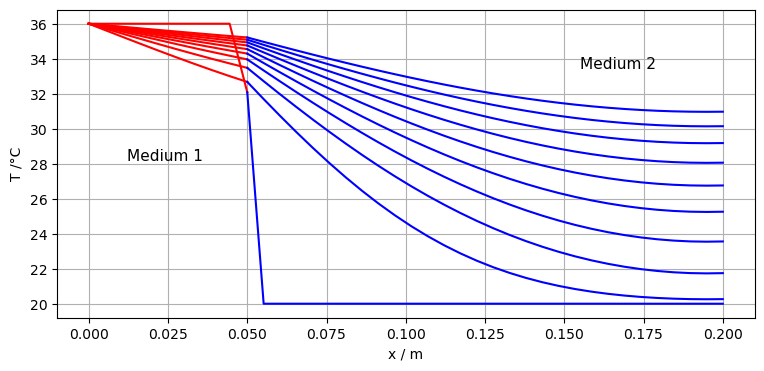

In [22]:
# Discretitations
Nx   = 10 # first medium
dx_0 = 0.005
Ny   = 30 # second medium
dy_0 = 0.005
Nt   = 6000
dt   = 10

Tc      = (b_1 * T_1 + b_2 * T_2) /(b_1 + b_2)

# Initial temperatures
T1 = np.zeros((Nx, Nt)) + 36
T2 = np.zeros((Ny, Nt)) + 20
T1[-1, 0] = Tc
T2[0, 0]  = Tc

# Thermal diffusivities
a_1 = lam_1 / rhocp_1
a_2 = lam_2 / rhocp_2

sx  = a_1**0.5 #for scaling x
sy  = a_2**0.5 #for scaling y

dx = 10
dy = dx
d1 = Nx * dx_0
d2 = Ny * dy_0

x  = np.linspace(0, d1, Nx)
y  = np.linspace(d1, d1+d2, Ny)

# Euler forward
for nt in range(0, Nt-1):
    for nx in range(1, Nx-1):
        T1[nx, nt+1] = T1[nx, nt] + dt / (dx*sx)**2 * a_1 * (T1[nx+1, nt] + T1[nx-1, nt] - 2*T1[nx, nt])
    T1[Nx-1, nt+1] = (T1[Nx-1, nt] + dt / ((dx*sx * rhocp_1 + dy*sy * rhocp_2) * 0.5) 
                    * (lam_1 / (dx*sx) * (T1[Nx-2, nt] - T1[Nx-1, nt]) -  lam_2 / (dy*sy) * (T2[0, nt] - T2[1, nt]))  )
    T2[0, nt+1]  = T1[Nx-1, nt+1] # Contacttemperature
    for ny in range(1, Ny-1):
        T2[ny, nt+1] = T2[ny, nt] + dt / (dy*sy)**2 * a_2 * (T2[ny+1, nt] + T2[ny-1, nt] - 2*T2[ny, nt])
    T2[Ny-1, nt+1] = T2[ny-1, nt] + dt / (dy*sy) * (T2[Ny-2, nt] - T2[Ny-1, nt]) * lam_2 /(0.5 * rhocp_2)
        
# Design a figure with plot-axes (ax)
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(x, T1[:, ::600], 'r-')
ax.plot(y, T2[:, ::600], 'b-')
ax.set_ylabel('T /°C')
ax.set_xlabel('x / m')
Med1 = "Medium 1"
Med2 = "Medium 2"
ax.text(0.1, .51, Med1, fontsize=11, transform=ax.transAxes)
ax.text(0.75, .81, Med2, fontsize=11, transform=ax.transAxes)
ax.grid()
plt.show()

In [21]:
print('Contact-temperature (t=0) =', f'{T1[-1, 0]:.2f}', '°C')

Contact-temperature (t=0) = 32.08 °C


```{admonition} Exercises
:class: full-width

What are the boundary conditions?

Does that make sense?

Now it's your turn! Modify 

- the discretisation in place and time
- the material properties and

write down what happens!

Are there differences to the exactly calculated values from equation {eq}`Tc`?
```